# Executive Summary

In [1]:
# This analysis looks at raw wind data from HPN from 2006-18 as recorded by the ASOS station on the field
# Data is recorded every hour from 2006-15 and every 5 minutes from 2016-18

# Data shows that during the last few years winds have favored 16 consistently more than they have during earlier periods
# In aggrigate during periods when the airport is most active 16 was recently favored ~25% more than 10+ years ago

# For 2013, 2015 and 2018 (years of the HMMH study) 16 winds increased from 28% to 34, and increase of 21%
# The above is in line with the increase in jet traffic observed by the study on 16 (+24% for 'day' and +18% for 'night')

# Based on the trend of winds favoring 16 along with the observed increases in actual traffic on 16 it is reasonable to conclude that changes in wind patterns is a primary, if not the primary, cause of increased traffic on the 16 approach path in recent years

In [2]:
# The code below will pull all the raw data from source, and conduct analysis and produce charts as reviewed by the HPN AAB

# Import Required Packages

In [15]:
from __future__ import print_function
import json
import time
import datetime
from urllib.request import urlopen

import os
import math
import matplotlib
import pandas as pd
import openpyxl

# Define Functions

## Data Fetching Service

In [4]:
# This service goes to the site below and automatically downloads data flat files into the /data folder

SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

# Inspired by https://github.com/akrherz/iem/blob/master/scripts/asos/iem_scraper_example.py

# Number of attempts to download data
MAX_ATTEMPTS = 6

def download_data(uri):
    """Fetch the data from the IEM
    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.
    Args:
      uri (string): URL to fetch
    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print("download_data(%s) failed with %s" % (uri, exp))
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""

def fetchASOS(stations, startts, endts):
    service = SERVICE + "data=all&tz=Etc/UTC&format=comma&latlon=yes&"

    service += startts.strftime("year1=%Y&month1=%m&day1=%d&")
    service += endts.strftime("year2=%Y&month2=%m&day2=%d&")
    
    for station in stations:
        uri = "%s&station=%s" % (service, station)
        print("Downloading: %s" % (station,))
        data = download_data(uri)
        outfn = "%s_%s_%s_%s.txt" % (
            'Data/',
            station,
            startts.strftime("%Y%m%d%H%M"),
            endts.strftime("%Y%m%d%H%M"),
        )
        out = open(outfn, "w")
        out.write(data)
        out.close()
        print("Wrote output: %s" % (outfn,))
        return str(outfn)

## Fetch for Defined Years and Airports

In [5]:
# Uses the above service to fetch data. Takes a list of airport IDs and years as inputs.

def importASOS(years, airports):
    df = pd.DataFrame()
    
    for airport in airports:
        print("Processing Airport: %s" % (airport,))
        for year in years:
            outfn = fetchASOS([airport], datetime.datetime(year, 1, 1), datetime.datetime(year, 12, 31))
            df = pd.concat([df, pd.read_csv(outfn, skiprows=5)])
            
            # Drop unused columns
            df = df[['station', 'valid', 'drct', 'sknt', 'vsby', 'skyc1', 'skyl1']]
            
            # Set the valid column as a timestamp
            df['valid'] = pd.to_datetime(df['valid'])
            
            # Add a column for the year
            df['year'] = df['valid'].dt.year
    
    return df

# Fetch Data for Analysis

In [6]:
airports = ['HPN']
years = [2006, 2007, 2008, 2009, 2010, 2011, 2012 ,2013, 2014, 2015, 2016, 2017, 2018, 2019]

#airports = ['HPN', 'LGA']
#years = [2013,2015,2018]

df = importASOS(years,airports)

# Pre-calculate some parameters to aid in later filtering and grouping
df['valid'] = pd.to_datetime(df['valid'])
df['hour'] = df['valid'].dt.hour
df['day'] = df['valid'].dt.dayofweek
df['month'] = df['valid'].dt.month
df.reset_index(drop=True, inplace=True)

Processing Airport: HPN
Downloading: HPN
Wrote output: Data/_HPN_200601010000_200612310000.txt
Downloading: HPN
Wrote output: Data/_HPN_200701010000_200712310000.txt
Downloading: HPN


/opt/anaconda3/envs/nthlab/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


Wrote output: Data/_HPN_200801010000_200812310000.txt
Downloading: HPN
Wrote output: Data/_HPN_200901010000_200912310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201001010000_201012310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201101010000_201112310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201201010000_201212310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201301010000_201312310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201401010000_201412310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201501010000_201512310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201601010000_201612310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201701010000_201712310000.txt
Downloading: HPN
Wrote output: Data/_HPN_201801010000_201812310000.txt


/opt/anaconda3/envs/nthlab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Downloading: HPN
Wrote output: Data/_HPN_201901010000_201912310000.txt


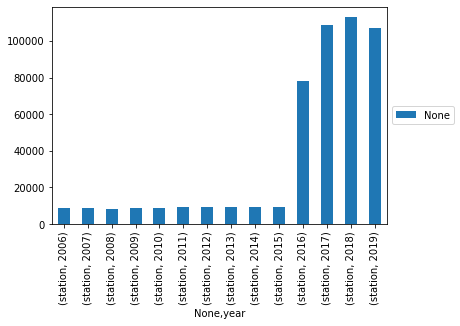

In [7]:
# We quickly check the number of datapoints recorded for each year
# Note that in 2016 the data goes from being recorded every hour to every 5 minutes

HPNg = df.groupby('year').count().station
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Define Wind Roses

In [8]:
# The wind rose below is defined around the main 16/34 runway at HPN. 
# ASOS data is 'true' and runway head headings are magnetic. HPN deviation is 13W.
# Wind readings are reported in 10 degree bins so 10 degress are subtracted from the ASOS readings to allign with runway orientation.

def HPN_Wind(airport, winddir):
    rwy = ''
    
    if airport == 'HPN':
        # A small number of readings are missing (likely due to station maintenance). These are omitted from the analysis
        if winddir == 'M':
            rwy = 'M'

        # The ASOS data records calm winds as having a heading of 0.00; North winds have a heading of 360.00
        if winddir in ['0.00']:
            rwy = 'Calm'
            
        # These wind directions would be direct crosswinds on the 16-34 runway    
        if winddir in ['240.00', '60.00']:
            rwy = 'Crosswind'

        # These wind directions would provide a headwind component favoring use of runway 16
        if winddir in ['70.00', '80.00', '90.00', '100.00', '110.00', '120.00', '130.00', '140.00', '150.00', '160.00', '170.00', '180.00', '190.00', '200.00', '210.00', '220.00', '230.00']:
            rwy = '16'

        # These wind directions would provide a headwind component favoring use of runway 34
        if winddir in ['250.00', '260.00', '270.00', '280.00', '290.00', '300.00', '310.00', '320.00', '330.00', '340.00', '350.00', '360.00', '10.00', '20.00', '30.00', '40.00', '50.00']:
            rwy = '34'
    else:
        rwy = 'NO ROSE'
            
    return(rwy)

# Analysis

## Determine Rwy Preference For Each Period

In [9]:
# Remove rows with missing wind direction data
df = df[df['drct'] != 'M']

In [10]:
for i in df.index:
    if df.at[i, 'station'] == 'HPN':
        df.at[i, 'Raw_Rwy_Preference'] = HPN_Wind(df.at[i, 'station'], df.at[i, 'drct'])
    else:
        df.at[i, 'Raw_Rwy_Preference'] = 'OTHER AIRPORT'

In [11]:
# View the raw data with runway preference added
df

,station,valid,drct,sknt,vsby,skyc1,skyl1,year,hour,day,month,Raw_Rwy_Preference
0,HPN,2006-01-01 00:56:00,360.00,6.00,3.00,OVC,700.00,2006,0,6,1,34
1,HPN,2006-01-01 01:56:00,360.00,5.00,2.50,OVC,700.00,2006,1,6,1,34
2,HPN,2006-01-01 02:56:00,350.00,7.00,3.00,OVC,700.00,2006,2,6,1,34
3,HPN,2006-01-01 04:56:00,10.00,5.00,6.00,OVC,700.00,2006,4,6,1,34
4,HPN,2006-01-01 05:56:00,350.00,4.00,5.00,SCT,700.00,2006,5,6,1,34
...,...,...,...,...,...,...,...,...,...,...,...,...
497092,HPN,2019-12-30 23:30:00,50.00,13.00,2.50,FEW,800.00,2019,23,0,12,34
497094,HPN,2019-12-30 23:40:00,60.00,9.00,2.50,FEW,800.00,2019,23,0,12,Crosswind
497095,HPN,2019-12-30 23:45:00,60.00,11.00,2.50,FEW,800.00,2019,23,0,12,Crosswind
497096,HPN,2019-12-30 23:50:00,50.00,11.00,2.50,FEW,800.00,2019,23,0,12,34


## Native Runway Preference for HPN

### All Times

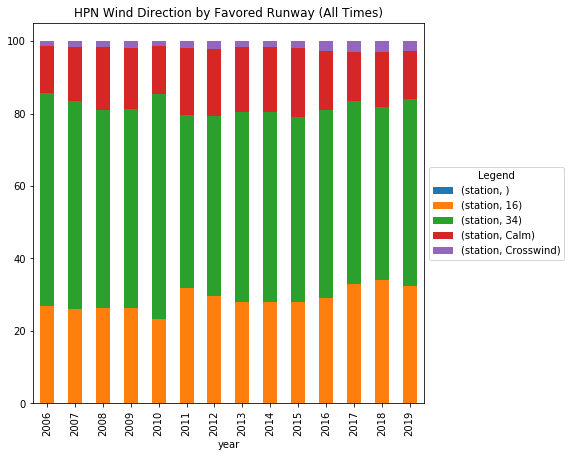

In [12]:
# Looking at all the data, we can see that the last several years have seen 16 winds much higher than historical levels going back to 2006

HPNg = df[df['station']=='HPN'].groupby(['year', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (All Times)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [19]:
HPNg.to_excel("GraphData/HPN_Wind_All_Times.xlsx") 

#### All Times - By Hour of Day (UTC)

#### All Times - By Month

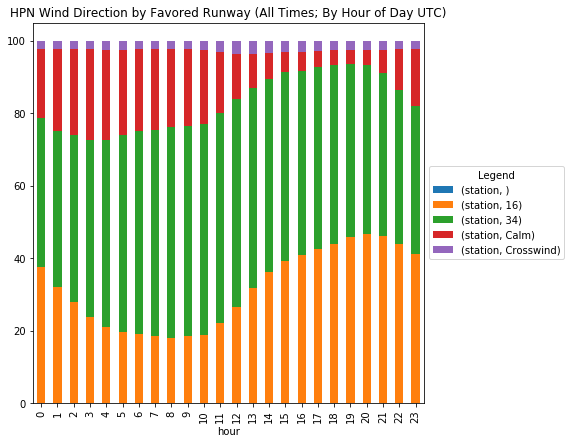

In [21]:
# Looking at the above by hour of day we see that 16 winds are most common during daylight hours, peaking around 20Z (2 or 3 PM local)
# Those afternoon periods also have very few periods with calm winds

HPNg = df[df['station']=='HPN'].groupby(['hour', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (All Times; By Hour of Day UTC)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [22]:
HPNg.to_excel("GraphData/HPN_Wind_All_Times-By_Hour.xlsx") 

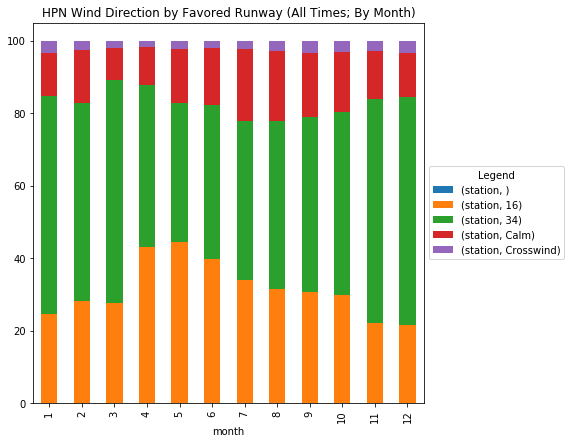

In [23]:
# Looking at the above by month we see some seasonality with spring into summer having more 16 winds than cooler months of the year

HPNg = df[df['station']=='HPN'].groupby(['month', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (All Times; By Month)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [24]:
HPNg.to_excel("GraphData/HPN_Wind_All_Times-By_Month.xlsx") 

#### All Times - By Day of Week (0 = Monday, 6 = Sunday)

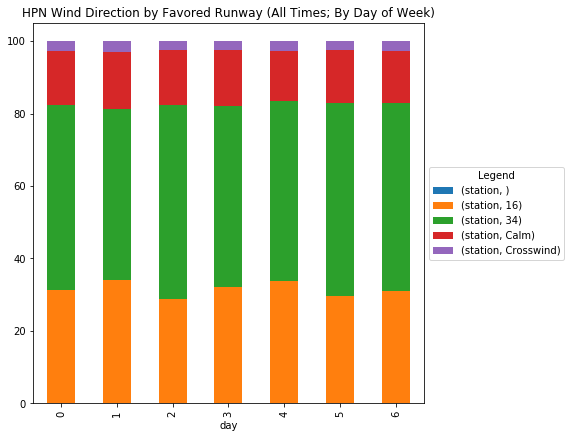

In [25]:
# Looking across the 14 years we see little consistent seasonality by day of week (as expected)
# As we will see later, certain years can develop localized patterns that do favor shorter term preferences (e.g. weekends)

HPNg = df[df['station']=='HPN'].groupby(['day', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (All Times; By Day of Week)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [26]:
HPNg.to_excel("GraphData/HPN_Wind_All_Times-By_DayofWeek.xlsx") 

### Excluding Overnight Periods

In [27]:
# All the above data looks at all hours of the day. But few flights arrive during the overnight hours (5Z - 12Z)
# The rest of the analysis below will exclude the overnight periods and focus on the times when the airport is generally active

dfControlled = df[(df['hour'] > 11) | (df['hour'] < 4)]

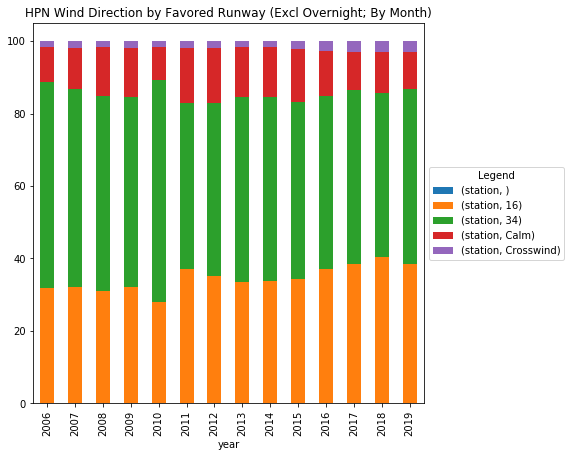

In [29]:
# Looking at the overal trend when overnight periods are excluded we again see recent years with high 16 winds

HPNg = dfControlled[dfControlled['station']=='HPN'].groupby(['year', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (Excl Overnight; By Month)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [30]:
HPNg.to_excel("GraphData/HPN_Wind_Excl_Overnight-By_Month.xlsx") 

### Excluding Overnight - 'Outdoor Months' (Apr, May, Jun, Jul, Aug, Sep, Oct)

In [49]:
dfControlledOutdoors = dfControlled[(dfControlled['month'] <= 10) & (dfControlled['month'] >= 4)]

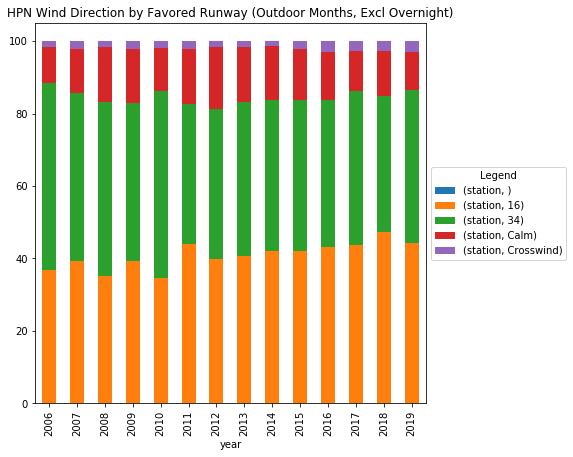

In [50]:
# Here we look just at 'outdoor months' where people are most likly to be outside during the daytime

HPNg = dfControlledOutdoors[dfControlledOutdoors['station']=='HPN'].groupby(['year', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (Outdoor Months, Excl Overnight)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [51]:
HPNg.to_excel("GraphData/HPN_Wind_Excl_Overnight_OutdoorMonths-By_Year.xlsx")  

#### 'Outdoor Months' by Hour of Day (UTC)

In [46]:
dfOutdoors = df[(df['month'] <= 10) & (df['month'] >= 4)]

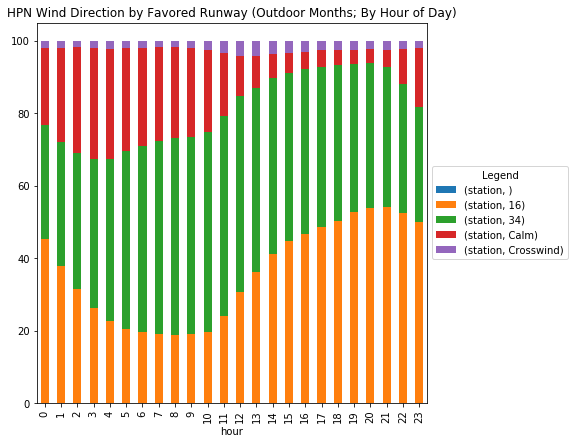

In [47]:
# Looking by hour of day we see that overnight periods have much less 16 winds and >20% calm winds... during afternoons there are few calm winds and 16 is the most common wind

HPNg = dfOutdoors[dfOutdoors['station']=='HPN'].groupby(['hour', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (Outdoor Months; By Hour of Day)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [48]:
HPNg.to_excel("GraphData/HPN_Wind_OutdoorMonths-By_Hour.xlsx") 

#### Excluding Overnight - 'Outdoor Months' (Apr, May, Jun, Jul, Aug, Sep, Oct) Sat & Sun Only

In [37]:
dfControlledOutdoorsWeekend = dfControlled[(dfControlled['month'] <= 10) & (dfControlled['month'] >= 4) & ((dfControlled['day'] == 5) | (dfControlled['day'] == 6))]

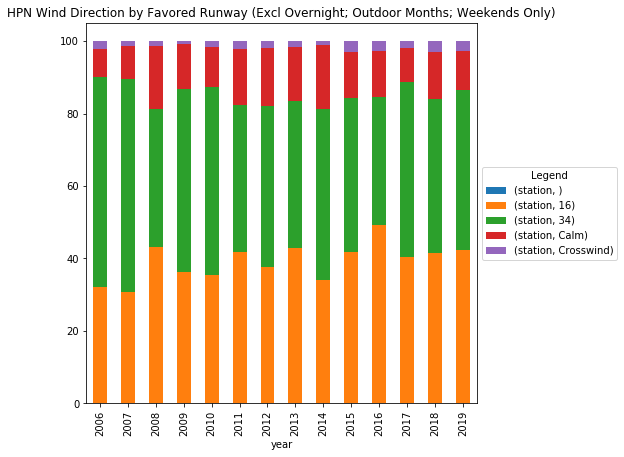

In [38]:
# Although across the whole dataset weekday has little impact, just looking at weekends during outdoor months (likely the most sensitive time) does show some significant yearly changes

HPNg = dfControlledOutdoorsWeekend[dfControlledOutdoorsWeekend['station']=='HPN'].groupby(['year', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (Excl Overnight; Outdoor Months; Weekends Only)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [39]:
HPNg.to_excel("GraphData/HPN_Wind_Excl_Overnight_WarmMonths_Weekends-By_Year.xlsx") 

### Excluding Overnight - 'Indoor Months' (Nov, Dec, Jan, Feb, Mar)

In [40]:
dfControlledIndoors = dfControlled[(dfControlled['month'] >= 11) | (dfControlled['month'] <= 3)]

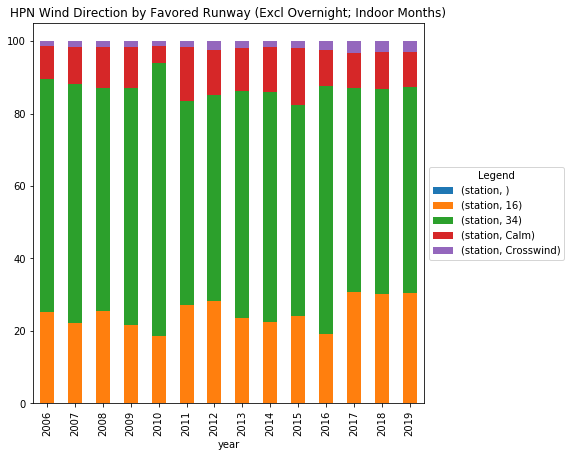

In [41]:
HPNg = dfControlledIndoors[dfControlledIndoors['station']=='HPN'].groupby(['year', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (Excl Overnight; Indoor Months)', figsize=(7,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [42]:
HPNg.to_excel("GraphData/HPN_Wind_Excl_Overnight_IndoorMonths-By_Year.xlsx") 

#### Excluding Overnight - 'Indoor Months' (Nov, Dec, Jan, Feb, Mar) Sat & Sun Only

In [43]:
dfControlledIndoorsWeekend = dfControlled[((dfControlled['month'] >= 11) | (dfControlled['month'] <= 3)) & ((dfControlled['day'] == 5) | (dfControlled['day'] == 6))]

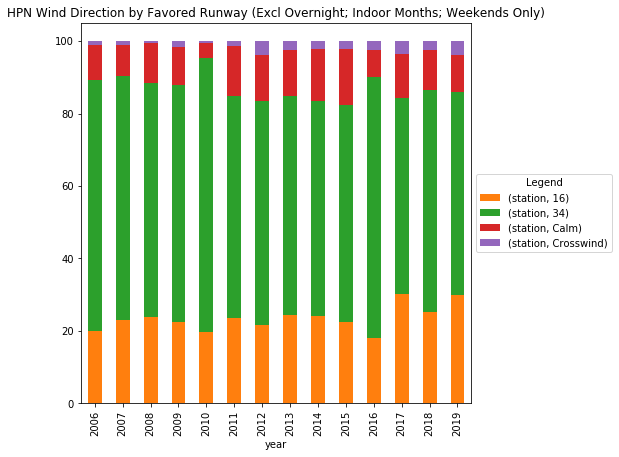

In [44]:
# The same analysis can be done looking at weekends during 'indoor' months; Of interest is that while 2016 had the most 16 winds in the summer weekends it had the least 16 winds on weekends during indoor months

HPNg = dfControlledIndoorsWeekend[dfControlledIndoorsWeekend['station']=='HPN'].groupby(['year', 'Raw_Rwy_Preference']).count().station
HPNg = HPNg.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
HPNg = pd.DataFrame(HPNg)
HPNg.unstack().plot(kind='bar', stacked=True, title='HPN Wind Direction by Favored Runway (Excl Overnight; Indoor Months; Weekends Only)', figsize=(7,7), color=['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']).legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')

In [45]:
HPNg.to_excel("GraphData/HPN_Wind_Excl_Overnight_IndoorMonths_Weekends-By_Year.xlsx") 